Can we just learn the function instead of deriving algorithms?


In [1]:
import sys
import os.path
import torch.nn
import torch.optim
import torch.utils.data
from torch.autograd import Variable
import numpy
import numpy.random
import scipy
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATADIR = "../data"
FEATRS = ["s-collected-negative.npy", "s-collected-positive.npy"]
LABELS = ["z-collected-negative.npy", "z-collected-positive.npy"]

Load the data.

In [3]:
data = []
for fname, lname in zip(FEATRS, LABELS):
    f = numpy.load(os.path.join(DATADIR, fname))
    l = numpy.load(os.path.join(DATADIR, lname))
    l = numpy.expand_dims(l, 2)
    data.append(numpy.concatenate([f, l], axis=2))

Take the same fraction from each part as the training set.

In [21]:
TRAIN_FRACTION = 0.8
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NEPOCHS = 50
HIDDEN_SIZE = 64
NUM_LAYERS = 3
BIDIRECTIONAL = True

In [22]:
train_data = []
test_data = []
for part in data:
    indices = numpy.arange(len(part))
    numpy.random.shuffle(indices)
    train_end = int(len(indices) * TRAIN_FRACTION)
    train_data.append(part[indices[:train_end]])
    test_data.append(part[indices[train_end:]])
train_data = numpy.concatenate(train_data, axis=0)
test_data = numpy.concatenate(test_data, axis=0)

In [23]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False)

The model is a multilayer LSTM, used to classify entries into regular and containing intrusion. We do not have enough positive intrusion event labels to detect individual events, so only overall intrusion/no intrusion classification is learned.

In [28]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lstm = torch.nn.LSTM(2, HIDDEN_SIZE, NUM_LAYERS, bidirectional=BIDIRECTIONAL)
        self.readout = torch.nn.Linear(HIDDEN_SIZE, 1)
        
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        result = self.readout(h[-1])
        return result

In [25]:
def makexy(batch):
    batch = batch.float()
    x = Variable(batch[:, :, :2])
    y = Variable(batch[:, :, 2:].sum(dim=0).sign())
    return x, y

In [26]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss = numpy.nan
test_loss =numpy.nan

# Train/test loop
iepoch = 0
loss_function = torch.nn.BCEWithLogitsLoss()

In [27]:
first_epoch = iepoch
while True:
    # Validate and test the model
    model.eval()
    test_loss = 0.
    for batch in test_loader:
        x, y = makexy(batch)
        
        # forward
        result = model(x)

        # loss
        batch_loss = loss_function(result, y)
        test_loss += batch_loss.data[0] * len(batch)

    test_loss /= len(test_loader.dataset)

    print("epoch {:4d}: train loss: {:.6g} test loss: {:.6g}"
          .format(iepoch, train_loss, test_loss))
    sys.stdout.flush()

    if iepoch == NEPOCHS + first_epoch:
        break
    iepoch += 1

    # Train the model
    model.train()
    train_loss = 0.
    for batch in train_loader:
        optimizer.zero_grad()

        x, y = makexy(batch)

        # forward
        result = model(x)
        preds = result[0]

        # loss
        batch_loss = loss_function(result, y)
        train_loss += batch_loss.data[0] * len(batch)

        # backward
        batch_loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)

/home/dvd/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


epoch    0: train loss: nan test loss: 0.660936


/home/dvd/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch    1: train loss: 0.530186 test loss: 0.469356
epoch    2: train loss: 0.482858 test loss: 0.441877
epoch    3: train loss: 0.455149 test loss: 0.442864
epoch    4: train loss: 0.460862 test loss: 0.436243
epoch    5: train loss: 0.453052 test loss: 0.435263
epoch    6: train loss: 0.451168 test loss: 0.430518
epoch    7: train loss: 0.441288 test loss: 0.466721
epoch    8: train loss: 0.443431 test loss: 0.426291
epoch    9: train loss: 0.449675 test loss: 0.437495
epoch   10: train loss: 0.440619 test loss: 0.442427
epoch   11: train loss: 0.454302 test loss: 0.425464
epoch   12: train loss: 0.444026 test loss: 0.426864
epoch   13: train loss: 0.442875 test loss: 0.424933
epoch   14: train loss: 0.439988 test loss: 0.425792
epoch   15: train loss: 0.443026 test loss: 0.420014
epoch   16: train loss: 0.442624 test loss: 0.42562
epoch   17: train loss: 0.447239 test loss: 0.421528
epoch   18: train loss: 0.435675 test loss: 0.415856
epoch   19: train loss: 0.435902 test loss: 0.4

In [32]:
model.eval()
x, y = makexy(torch.from_numpy(test_data.transpose(1, 0, 2)))
y = y.data.resize(len(y))
result = torch.nn.Sigmoid()(model(x)).data
result = result.resize(len(result))

torch.Size([50, 200, 2]) torch.Size([200, 1])


/home/dvd/miniconda3/lib/python3.6/site-packages/torch/tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Let us draw ROC on the training set and compute the AUC.

Text(0.5,1,'auc = 0.6016')

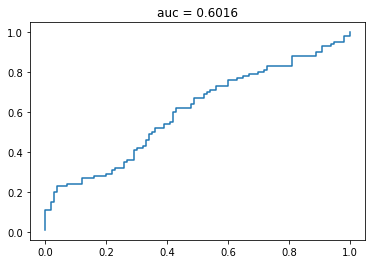

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(y.data, result, pos_label=True)
plt.plot(fpr, tpr)
auc = metrics.auc(fpr, tpr)
plt.title("auc = {:.4f}".format(auc))

The accuracy is similar to detecting based on marks only. The use of deep learning is still possible but more complicated than just training an LSTM-based classifier.